# 금리 데이터 크롤링, Raw Data 추출

In [14]:
# Call Rate Crawling

import requests
from bs4 import BeautifulSoup
import pandas as pd

start_page = 1
end_page = 544

page_number = 1

date_list = []
rate_list = []

while True:
    URL = 'https://finance.naver.com/marketindex/interestDailyQuote.nhn?marketindexCd=IRR_CALL&page={}'.format(page_number)
    r = requests.get(URL)
    sp = BeautifulSoup(r.text,'html.parser')
    results = sp.select('tr')[1:]
    for result in results:
        date_list.append(result.select_one('td.date').text.strip())
        rate_list.append(result.select_one('td.num').text.strip())

    page_number += 1
    if page_number > end_page:
        break

call_df = pd.DataFrame(list(zip(date_list,rate_list)))

In [15]:
call_df.columns = ['date','rate']

In [16]:
call_df

,date,rate
0,2020.07.30,0.49
1,2020.07.29,0.48
2,2020.07.28,0.47
3,2020.07.27,0.49
4,2020.07.24,0.48
...,...,...
3803,2005.04.04,3.24
3804,2005.04.01,3.25
3805,2005.03.31,3.26
3806,2005.03.30,3.25


In [17]:
import datetime

In [18]:
call_df['date'] = list(map(lambda i : datetime.datetime.strptime(i, '%Y.%m.%d'), list(call_df['date'])))

In [33]:
call_df

,date,rate
0,2020-07-30,0.49
1,2020-07-29,0.48
2,2020-07-28,0.47
3,2020-07-27,0.49
4,2020-07-24,0.48
...,...,...
3803,2005-04-04,3.24
3804,2005-04-01,3.25
3805,2005-03-31,3.26
3806,2005-03-30,3.25


In [21]:
start_date = call_df['date'][len(call_df)-1]
end_date = call_df['date'][0]

print(start_date, end_date)

day_range = (end_date - start_date).days

temp = []
for i in range(day_range):
    temp.append((start_date + datetime.timedelta(i)).date())

call_final = pd.DataFrame(temp, columns = ['date']).set_index('date', inplace = True)

In [42]:
call_final['rate'] = call_df.set_index('date').rate

In [46]:
call_final.fillna(method='pad', inplace=True)

In [48]:
call_final.to_json('call_raw.json')

## Ngram 빈 리스트 처리 (For문은 느림)

In [221]:
#최초 Ngram에서 빈 리스트 제거
for i in range(len(ngram_df)):
    if ngram_df['ngram'][i] == []:
        ngram_df.drop(i, axis=0, inplace=True)
ngram_df

,date,ngram,ud
0,2005-05-12,"[부진/NNG;글로벌/NNG;경기/NNG;둔화/NNG;우려/NNG, 소비/NNG;설...",0
1,2005-06-09,"[경상/NNG;수지/NNG;적자/NNG;재정/NNG;적자/NNG, 국제/NNG;금융...",down
2,2005-06-23,"[대출/NNG;촉진/NNG, 걸림돌/NNG, 개선/NNG]",0
3,2005-07-07,"[자산/NNG;가격/NNG;상승/NNG;물가/NNG;상승/NNG, 물가/NNG;안정...",up
4,2005-08-11,"[부동산/NNG;가격/NNG;상승/NNG;금리/NNG;인상/NNG, 국채/NNG;수...",0
...,...,...,...
305067,2020-07-15,"[실망/NNG, 중단/NNG]",NaN
305068,2020-07-15,"[경기/NNG;침체/NNG, 완화/NNG]",NaN
305069,2020-07-15,"[코픽스/NNG;떨어/VV, 돈/NNG;확보/NNG, 하락/NNG, 내림/NNG]",NaN
305070,2020-07-15,"[저축성/NNG;예금/NNG;늘/VV, 경기/NNG;악화/NNG, 통화/NNG;급증...",NaN


# Ngram 전처리

In [1]:
import pandas as pd
train_df = pd.read_json('train_data.json')
train_df['date'] = list(map(lambda i : i.date(), train_df['date']))

In [2]:
train_df['ngram']

0         [부진/NNG;글로벌/NNG;경기/NNG;둔화/NNG;우려/NNG, 소비/NNG;설...
1         [경상/NNG;수지/NNG;적자/NNG;재정/NNG;적자/NNG, 국제/NNG;금융...
2                          [대출/NNG;촉진/NNG, 걸림돌/NNG, 개선/NNG]
3         [자산/NNG;가격/NNG;상승/NNG;물가/NNG;상승/NNG, 물가/NNG;안정...
4         [부동산/NNG;가격/NNG;상승/NNG;금리/NNG;인상/NNG, 국채/NNG;수...
                                ...                        
292539              [매출/NNG;감소/NNG, 피해/NNG, 최대/NNG, 개선/NNG]
292540    [경기/NNG;판단/NNG;상승/NNG, 경기/NNG;전망/NNG;하락/NNG, 전...
292541    [소비자/NNG;심리/NNG;긍정적/VAX, 지표/NNG;낮/VA, 하락/NNG, ...
292542    [주택가격/NNG;전망/NNG;상승/NNG, 취업기회/NNG;전망/NNG;오르/VV...
292543    [자산/NNG;가격/NNG;하락/NNG, 지수/NNG;저점/NNG;상승/NNG, 경...
Name: ngram, Length: 292544, dtype: object

In [3]:
train_df.isnull().sum()

date     0
ngram    0
ud       0
dtype: int64

In [4]:
import itertools
total_ngram = list(itertools.chain(*list(train_df['ngram'])))

In [5]:
len(total_ngram)

3197735

In [6]:
ngram_feature = set(total_ngram)

In [7]:
len(ngram_feature)

65447

In [8]:
counts = []
for nf in ngram_feature:
    counts.append(total_ngram.count(nf))

ngram_count = pd.DataFrame(list(zip(ngram_feature, counts)), columns = ['ngram', 'count'])

In [11]:
ngram_count.to_json('ngram_count.json')

In [10]:
ngram_count[ngram_count['count']<=15]

,ngram,count
1,우려/NNG;시장/NNG;경계/NNG,7
2,부동산/NNG;가격/NNG;잡/VV;금리/NNG;인상/NNG,3
4,헤알/NNG;환율/NNG;떨어/VV,10
7,기대/NNG;방어/NNG,4
10,gdp/NNG;성장률/NNG;시장/NNG;예상/NNG;하회/NNG,4
...,...,...
65434,소비/NNG;더디/VA;회복/NNG,7
65437,정책/NNG;확보/NNG,8
65440,지급불능/NNG;위험/NNG,12
65444,기업/NNG;많/VA;반대/NNG,1


# -------- NLTK 쓰기 전 Ngram 카운팅 했던 것 (소요시간 1시간 30분)

In [74]:
import pandas as pd
import numpy as np
import itertools
import nltk

# 데이터프레임은 인덱스에 단어, 칼럼에 타겟

# input - split된 단어 list
class NBC():
    
    df = pd.DataFrame([])
    k = 0.5

    def __init__(self, **kwargs):
        try:
            self.k = kwargs['k']
        except:
            pass
    
    def add_data(self, datas):
        target_ls = list(set(datas['ud']))
        words = {}

        total_ngram = list(itertools.chain(*list(train_df['ngram'])))
        unique_ngram = list(set(total_ngram))

        result_df = pd.DataFrame(unique_ngram, columns = ['ngram']).set_index('ngram')

        for target in target_ls:
            this_ngram = list(itertools.chain(*list(datas[datas['ud'] == target]['ngram'])))
            fdist = nltk.FreqDist(this_ngram)
            temp_df = pd.DataFrame(list(zip(fdist.keys(), fdist.values())), columns= ['ngram', 'count']).set_index('ngram')
            result_df[target] = temp_df['count']

        self.df = result_df
        return self.df

    def pol_score(self, target, s):
        df = self.df
        k = self.k

        totals = {}
        for i in df:
            totals[i] = df[i].sum()
        
        tokens = s.split()
        total = np.asarray(list(totals.values())).sum()

        logs = {}
        for i in df:            
            logs[i] = np.log(float(totals[i]) / float(total))
        
        for token in tokens:
            for t in df:
                logs[t] += np.log( (k + df[t][token]) / (2*k +totals[t]) )

        bunmo = 0
        for log in logs:
            bunmo += np.exp(logs[log])
        bunja = np.exp(logs[target])
        return bunja / bunmo

In [18]:
nbc = NBC(k=0.05)

In [19]:
train_df

,date,ngram,ud
0,2005-05-12,"[부진/NNG;글로벌/NNG;경기/NNG;둔화/NNG;우려/NNG, 소비/NNG;설...",0
1,2005-06-09,"[경상/NNG;수지/NNG;적자/NNG;재정/NNG;적자/NNG, 국제/NNG;금융...",down
2,2005-06-23,"[대출/NNG;촉진/NNG, 걸림돌/NNG, 개선/NNG]",0
3,2005-07-07,"[자산/NNG;가격/NNG;상승/NNG;물가/NNG;상승/NNG, 물가/NNG;안정...",up
4,2005-08-11,"[부동산/NNG;가격/NNG;상승/NNG;금리/NNG;인상/NNG, 국채/NNG;수...",0
...,...,...,...
292539,2020-06-26,"[매출/NNG;감소/NNG, 피해/NNG, 최대/NNG, 개선/NNG]",0
292540,2020-06-26,"[경기/NNG;판단/NNG;상승/NNG, 경기/NNG;전망/NNG;하락/NNG, 전...",0
292541,2020-06-26,"[소비자/NNG;심리/NNG;긍정적/VAX, 지표/NNG;낮/VA, 하락/NNG, ...",0
292542,2020-06-26,"[주택가격/NNG;전망/NNG;상승/NNG, 취업기회/NNG;전망/NNG;오르/VV...",0


In [20]:
nbc.add_data(train_df)

,0,down,up
ngram,,,
경제/NNG;성장/NNG;낮/VA,21.0,15.0,2.0
신용/NNG;좋/VA,23.0,9.0,7.0
비농업/NNG;고용/NNG;시장/NNG;예상/NNG;하회/NNG,8.0,NaN,NaN
억제/NNG;넘/VV,NaN,1.0,NaN
강하/VA;추세/NNG,23.0,2.0,19.0
...,...,...,...
점차/MAG;금리/NNG;상승/NNG;압력/NNG;높/VA,1.0,NaN,NaN
자금/NNG;압박/NNG;심하/VA,7.0,8.0,1.0
물가/NNG;예상/NNG;벗어나/VV;않/VX,1.0,NaN,NaN


In [21]:
nbc.df.fillna(0)

,0,down,up
ngram,,,
경제/NNG;성장/NNG;낮/VA,21.0,15.0,2.0
신용/NNG;좋/VA,23.0,9.0,7.0
비농업/NNG;고용/NNG;시장/NNG;예상/NNG;하회/NNG,8.0,0.0,0.0
억제/NNG;넘/VV,0.0,1.0,0.0
강하/VA;추세/NNG,23.0,2.0,19.0
...,...,...,...
점차/MAG;금리/NNG;상승/NNG;압력/NNG;높/VA,1.0,0.0,0.0
자금/NNG;압박/NNG;심하/VA,7.0,8.0,1.0
물가/NNG;예상/NNG;벗어나/VV;않/VX,1.0,0.0,0.0


In [28]:
nbc.pol_score(0, '경제/NNG;성장/NNG;낮/VA')

0.5517693591307893

In [39]:
pd.read_json('test_data.json')

,date,sent
0,2020-06-24,관련부서는 금번 보고서 작성의 기본방향과 위원협의회에서 논의된 주요 내용 을 다음과...
1,2020-06-24,먼저 금번 보고서에서는 코로나19 확산에 따른 유례없는 금융·실물 충격이 금 융시스...
2,2020-06-24,다음으로 6월 11일 위원협의회에서 논의된 내용은 다음과 같음
3,2020-06-24,여러 위원들은 금번 보고서가 코로나19 확산 이후 금융불안 우려가 높아진 상황에서 ...
4,2020-06-24,일부 위원은 코로나19 확산 이후 금융시장 상황이 빠르게 변하고 있는 점을 감안하여...
...,...,...
38104,2005-05-12,"Dow Jones 지수는 미국의 1/4분기 GDP성장률 둔화(, 전분기 ) 등 경제..."
38105,2005-05-12,"유럽 주가는 유로지역 경제에 대한 비관적 전망, 인피니언사 등 주요 기업들의 실적부..."
38106,2005-05-12,유로화는 유로지역 경제 부진 전망 등으로 약세( 절하)를 보였으나 일본 엔화는 미국...
38107,2005-05-12,"미국의 장기금리는 미국의 경제성장률 둔화, 주가 하락 등으로 안전자산인 국채선호 경..."


In [38]:
train_df.columns[0]

'date'

In [7]:
nbc.df.to_json('train_result.json')

In [53]:
test_df['ngram'] = ngram_ls

In [55]:
# Ngram 빈 list 처리
train_df['ngram'] = list(map(lambda i : None if i == [] else i, train_df['ngram']))

test_df.isnull().sum()
test_df.dropna(inplace=True)

date        0
sent        0
ngram    8687
dtype: int64

In [57]:
nbc = NBC(train_data)

In [34]:
train_data['ud'] == 1.0

date
2005-05-12    False
2005-06-09     True
2005-06-23    False
2005-07-07    False
2005-08-11     True
              ...  
2017-12-31    False
2017-12-31    False
2017-12-31    False
2017-12-31    False
2017-12-31    False
Name: ud, Length: 243973, dtype: bool

In [58]:
nbc.add_data(train_data)

,0.0,1.0,-1.0
ngram,,,
생산성/NNG;개선/NNG,27.0,16.0,18.0
채권/NNG;거래/NNG;증가/NNG,11.0,3.0,3.0
외화차입/NNG;여건/NNG;악화/NNG,15.0,13.0,9.0
고용/NNG;선순환/NNG,8.0,1.0,0.0
중소기업/NNG;금리/NNG;인하/NNG,13.0,0.0,5.0
...,...,...,...
경제/NNG;성장/NNG;미약/NNG,15.0,4.0,12.0
약화/NNG;국채/NNG;가격/NNG;하락/NNG,7.0,5.0,3.0
높/VA;금융시장/NNG;불안/NNG,10.0,4.0,4.0


In [26]:
hawkish

Index(['주문/NNG;금리/NNG;인상/NNG', '인상/NNG;제약/NNG',
       '인플레이션/NNG;기대/NNG;확산/NNG;방지/NNG', '예상/NNG;환율/NNG;상승/NNG',
       '저축성/NNG;예금/NNG;금리/NNG;상승/NNG', '금리/NNG;인하/NNG;아니/VCN;금리/NNG;인하/NNG',
       '물가/NNG;안정/NNG;경제/NNG;안정/NNG', '둔화/NNG;우려/NNG;아니/VCN',
       '생산/NNG;지표/NNG;악화/NNG', 'fx스왑/NNG;시장/NNG;마이너스/NNG',
       ...
       '거품/NNG;없/VA', '경기/NNG;둔화/NNG;가능성/NNG;크/VV', '하락/NNG;꺾/VV',
       '금리/NNG;인상/NNG;급하/VA;않/VX', '미/NNG;건설/NNG;지출/NNG;감소/NNG',
       '활성화/NNG;금리/NNG;인상/NNG', '금리/NNG;하락/NNG;견인력/NNG;약화/NNG',
       '상향/NNG;힘입/VV;강세/NNG', '물가/NNG;아니/VCN;성장/NNG',
       '금리/NNG;인상/NNG;불구/NNG;상승/NNG'],
      dtype='object', name='ngram', length=25243)

In [17]:
nbc.df[[1,-1]].sum().sum()

1240873.0

In [27]:
dovish

Index(['고용시장/NNG;낙관/NNG', '둔화/NNG;강세/NNG', '가계/NNG;금리/NNG;부담/NNG',
       '금리/NNG;인플레이션/NNG;낮/VA', '인하/NNG;환율/NNG;방어/NNG',
       '내외/NNG;금리갭/NNG;축소/NNG', '급락/NNG;원화/NNG;약세/NNG', '자산/NNG;듀레이션/NNG;길/VA',
       '인하/NNG;가계/NNG;부채/NNG;증가/NNG;우려/NNG', '부진/NNG;발목/NNG;잡/VV',
       ...
       '해외/NNG;주식펀드/NNG;수익률/NNG;상승/NNG', '글로벌/NNG;유동성/NNG;확대/NNG',
       'ecb/NNG;금리/NNG;내리/VV;금리/NNG;인하/NNG', '생산/NNG;소비/NNG;둔화/NNG',
       '위험자산/NNG;부정적/VAX', '회사채/NNG;시장/NNG;충격/NNG', '외국인/NNG;채권투자/NNG;급증/NNG',
       '금리/NNG;당분간/MAG;인하/NNG', '수익성/NNG;현금흐름/NNG;개선/NNG', '크레딧/NNG;안정/NNG'],
      dtype='object', name='ngram', length=23563)

1240873


,1.0,-1.0,haw,dov,score
ngram,,,,,
거품/NNG,474.0,386.0,0.000715,0.000668,1.069115
주문/NNG;금리/NNG;인상/NNG,4.0,0.0,0.000006,0.000000,inf
산업/NNG;어렵/VA,3.0,3.0,0.000005,0.000005,0.870630
고용시장/NNG;낙관/NNG,1.0,3.0,0.000002,0.000005,0.290210
둔화/NNG;강세/NNG,2.0,3.0,0.000003,0.000005,0.580420
...,...,...,...,...,...
회사채/NNG;시장/NNG;충격/NNG,0.0,3.0,0.000000,0.000005,0.000000
외국인/NNG;채권투자/NNG;급증/NNG,3.0,6.0,0.000005,0.000010,0.435315
금리/NNG;당분간/MAG;인하/NNG,2.0,3.0,0.000003,0.000005,0.580420


In [6]:
import numpy as np

np.inf<0

False

In [18]:
import pandas as pd
import numpy as np
import itertools
import nltk

class NBC():
    def add_data(self, datas):
        word_column = datas.columns[0]
        target_column = datas.columns[1]
        target_ls = list(set(datas[target_column]))
        # list가 아닐 경우 실행
        # datas[word_column] = list(map(lambda i : i.split(','), datas[word_column]))

        total_ngram = list(itertools.chain(*list(datas[word_column]))) 
        unique_ngram = list(set(total_ngram))
        result_df = pd.DataFrame(unique_ngram, columns = [word_column]).set_index(word_column)

        for target in target_ls:
            this_ngram = list(itertools.chain(*list(datas[datas[target_column] == target][word_column])))
            fdist = nltk.FreqDist(this_ngram)
            temp_df = pd.DataFrame(list(zip(fdist.keys(), fdist.values())), columns= [word_column, 'count']).set_index(word_column)
            result_df[target] = temp_df['count']
        
        self.df = result_df.fillna(0)
        return self.df

    def polarity_score(self):
        df = self.df
        df['haw'] = df[1] / sum(df[1])
        df['dov'] = df[-1] / sum(df[-1])
        df['score'] = df['haw'] / df['dov']
        return self.df

In [ ]:
import pandas as pd
ngram_df = pd.read_json('final_ngram_comma.json')
ngram_df['date'] = list(map(lambda i : i.date(), ngram_df['date']))
ngram_df.set_index('date', inplace=True)

cd_df = pd.read_json('labeled_cd_rate.json')
cd_df['date'] = list(map(lambda i : i.date(), cd_df['date']))
cd_df.set_index('date', inplace=True)

ngram_df['ud'] = cd_df['ud']

import datetime
train_data = ngram_df.iloc[(ngram_df.index >= datetime.date(2005,5,1)) & (ngram_df.index <= datetime.date(2017,12,31))]

# train_data = train_data[train_data['ud']!=0]

In [ ]:
nbc = NBC()
nbc.add_data(train_data)
nbc.polarity_score()

nbc.df = nbc.df[nbc.df[1,0,-1].sum(axis=1) > 15]

hawkish = nbc.df[nbc.df['score'] >= 1.3].index
dovish = nbc.df[nbc.df['score'] <= 10/13].index

# 삽질, 똥 싸놓은 것

In [50]:
import pandas as pd
import numpy as np
import itertools
import nltk
from sklearn.model_selection import train_test_split

# Input 데이터프레임은 첫 번째 column에 words(split처리 된 list), 두 번째 column에 target
# Output 데이터프레임은 인덱스에 단어, 칼럼에 타겟
class NBC():
    df = pd.DataFrame([])
    k = 0.5
    
    # 최초 모든 feature를 가지는 행렬 필요 initial_data
    def __init__(self, datas, **kwargs):
        self.raw_data = datas
        word_column = datas.columns[0]
        total_ngram = list(itertools.chain(*list(map(lambda i : i.split(','), datas[word_column])))) # list로 들어가지 않을 경우
        unique_ngram = list(set(total_ngram))
        self.init_df = pd.DataFrame(unique_ngram, columns = [word_column]).set_index(word_column)
        try:
            self.k = kwargs['k']
        except:
            pass
            
    # train data 받아서 count 행렬 반환하는 함수 #함수명 변경 
    def add_data(self, datas):
        word_column = datas.columns[0]
        target_column = datas.columns[1]
        target_ls = list(set(datas[target_column]))
        datas[word_column] = list(map(lambda i : i.split(','), datas[word_column]))
        

        total_ngram = list(itertools.chain(*list(datas[word_column]))) # list로 들어가지 않을 경우
        
        unique_ngram = list(set(total_ngram))

        result_df = pd.DataFrame(unique_ngram, columns = [word_column]).set_index(word_column)

        for target in target_ls:
            this_ngram = list(itertools.chain(*list(datas[datas[target_column] == target][word_column])))
            fdist = nltk.FreqDist(this_ngram)
            temp_df = pd.DataFrame(list(zip(fdist.keys(), fdist.values())), columns= [word_column, 'count']).set_index(word_column)
            result_df[target] = temp_df['count']
        
        self.df = result_df.fillna(0)
        return self.df
    
    # real polarity Score 계산 함수 필요
    def polarity(self, df):
        c_df = self.add_data(df)
        
        pola_list = []
        # self.initial data set
        for i in c_df.index:
            try:
                pola = self.pol_score(c_df, 1, i) / self.pol_score(c_df, -1, i)
            except:
                pola = 1
            pola_list.append(pola)
        
        word_column = self.raw_data.columns[0]
        temp_df = pd.DataFrame(c_df.index, columns = [word_column])
        temp_df.set_index(word_column, inplace=True)
        temp_df['x'] = pola_list
        
        #initial data에 polarity score 추가
        self.init_df[len(self.init_df.columns)+1] = temp_df['x']

    # 30번 돌리는 것은 ngram feature의 polarity score, 평균내서 hawkish, dovish 구분
    # feature의 Polarity Score > 1 이면, hawkish else dovish 
    # polarity score 계산 시 1.3 이하면 neutral word로 (hawkish, neutral, dovish))

    # 최종 ngram 별 hawkish, dovish 사전 구축

    # Tone 계산 함수

    # for문 돌려서 feature 별 polarity score 계산
    # polarity score = pol_score('up') / pol_score('down')

    def pol_score(self, datas, target, s):
        df = datas
        k = self.k

        totals = {}
        for i in df:
            totals[i] = df[i].sum()
        
        tokens = s.split()
        total = np.asarray(list(totals.values())).sum()

        logs = {}
        for i in df:            
            if total == 0:
                return None
#                 logs[i] = 0
            else:
                logs[i] = np.log(float(totals[i]) / float(total))
        
        for token in tokens:
            for t in df:
                try:
                    logs[t] += np.log( (k + df[t][token]) / (2*k +totals[t]) )
                except:
                    logs[t] += np.log( (k) / (2*k +totals[t]) )

        bunmo = 0
        for log in logs:
            bunmo += np.exp(logs[log])
        bunja = np.exp(logs[target])
        return bunja / bunmo

    def fit_data(self):
        datas = self.raw_data
        for i in range(30):
            train_X, test_X, train_y, test_y = train_test_split(datas['ngram'], datas['ud'], 
                                                                shuffle=True, test_size=0.1)
            train_X = pd.DataFrame(train_X, columns = ['ngram'])
            train_X['ud'] = train_y
            self.polarity(train_X)
        result = pd.DataFrame(self.init_df.index, columns = ['ngram'])
        result['pol'] = self.init_df.mean(axis = 1)

        return result


    def predict(self, test_datas):

        return

In [57]:
ngram_df = pd.read_json('final_ngram_comma.json')
ngram_df['date'] = list(map(lambda i : i.date(), ngram_df['date']))
ngram_df.set_index('date', inplace=True)

In [58]:
cd_df = pd.read_json('labeled_cd_rate.json')
cd_df['date'] = list(map(lambda i : i.date(), cd_df['date']))
cd_df.set_index('date', inplace=True)

In [59]:
ngram_df['ud'] = cd_df['ud']

In [20]:
import pandas as pd
ngram_df = pd.read_json('final_ngram_comma.json')
ngram_df['date'] = list(map(lambda i : i.date(), ngram_df['date']))
ngram_df.set_index('date', inplace=True)

cd_df = pd.read_json('labeled_cd_rate.json')
cd_df['date'] = list(map(lambda i : i.date(), cd_df['date']))
cd_df.set_index('date', inplace=True)

ngram_df['ud'] = cd_df['ud']

import datetime
train_data = ngram_df.iloc[(ngram_df.index >= datetime.date(2005,5,1)) & (ngram_df.index <= datetime.date(2017,12,31))]

train_data = train_data[train_data['ud']!=0]

In [94]:
train_data['ngram'] = list(map(lambda i : ' '.join(i.split(',')), train_data['ngram']))

In [44]:
import itertools
len(set(itertools.chain(*train_data['ngram'])))

58747

# 20200802 작업한 것

In [49]:
import pandas as pd
pd.read_json('call_raw.json')

,rate
2005-03-29,3.24
2005-03-30,3.25
2005-03-31,3.26
2005-04-01,3.25
2005-04-02,3.25
...,...
2020-07-25,0.48
2020-07-26,0.48
2020-07-27,0.49
2020-07-28,0.47


In [15]:
# 금리 라벨링 함수
import pandas as pd
import datetime

def rate_label(datas, date_count, rate_limit):

    temp = []
    for i in range(len(datas)-date_count):
        rate_change = float(datas['rate'][i+date_count]) - float(datas['rate'][i])
        if rate_change >= rate_limit:
            temp.append(1)
        elif rate_change <= -rate_limit:
            temp.append(-1)
        else:
            temp.append(0)

    temp
    new_data = datas.iloc[:-date_count]
    new_data['ud'] = temp
    new_data.reset_index(inplace=True)
    new_data.columns = ['date', 'rate', 'ud']
    new_data['date'] = list(map(lambda i : i.date(), new_data['date']))
    new_data.to_json('call_{}_{}.json'.format(str(date_count), str(rate_limit)))

In [53]:
list(range(5,31,5))

[5, 10, 15, 20, 25, 30]

In [16]:
# 금리 Raw 데이터에서 기간, 금리 변동 별로 Labeling
datas = pd.read_json('call_raw.json')
date_count = range(5,31, 5)
rate_limit = [0.01, 0.02, 0.03]

for dc in date_count:
    for rl in rate_limit:
        rate_label(datas, dc, rl)


In [66]:
train_data = pd.read_json('final_ngram_comma.json')

In [6]:
from ngram import ngram

In [7]:
ng = ngram.ngram()

In [17]:
ng.search('rate_data')

['rate_data\\call_10_0.01.json',
 'rate_data\\call_10_0.02.json',
 'rate_data\\call_10_0.03.json',
 'rate_data\\call_15_0.01.json',
 'rate_data\\call_15_0.02.json',
 'rate_data\\call_15_0.03.json',
 'rate_data\\call_20_0.01.json',
 'rate_data\\call_20_0.02.json',
 'rate_data\\call_20_0.03.json',
 'rate_data\\call_25_0.01.json',
 'rate_data\\call_25_0.02.json',
 'rate_data\\call_25_0.03.json',
 'rate_data\\call_30_0.01.json',
 'rate_data\\call_30_0.02.json',
 'rate_data\\call_30_0.03.json',
 'rate_data\\call_5_0.01.json',
 'rate_data\\call_5_0.02.json',
 'rate_data\\call_5_0.03.json']

In [58]:
import pandas as pd
import numpy as np
import itertools
import nltk
import copy

class NBC():
    def add_data(self, datas):
        word_column = datas.columns[0]
        target_column = datas.columns[1]
        target_ls = list(set(datas[target_column]))
        # list가 아닐 경우 실행
        # datas[word_column] = list(map(lambda i : i.split(','), datas[word_column]))

        total_ngram = list(itertools.chain(*list(datas[word_column]))) 
        unique_ngram = list(set(total_ngram))
        result_df = pd.DataFrame(unique_ngram, columns = [word_column]).set_index(word_column)
        for target in target_ls:
            this_ngram = list(itertools.chain(*list(datas[datas[target_column] == target][word_column])))
            fdist = nltk.FreqDist(this_ngram)
            temp_df = pd.DataFrame(list(zip(fdist.keys(), fdist.values())), columns= [word_column, 'count']).set_index(word_column)
            result_df[target] = temp_df['count']
        
        result_df.fillna(0, inplace=True)
        result_df['score'] = 0
        self.df = copy.deepcopy(result_df)
        return self.df
        # self.df['score'] = 0
        # return self.df
        # result_df.fillna(0, inplace=True)
        # result_df['score'] = 0
        # return result_df

    def count_vec(self, datas):
        word_column = datas.columns[0]
        target_column = datas.columns[1]
        target_ls = list(set(datas[target_column]))

        total_ngram = list(itertools.chain(*list(datas[word_column]))) 
        unique_ngram = list(set(total_ngram))
        result_df = pd.DataFrame(unique_ngram, columns = [word_column]).set_index(word_column)
        
        for target in target_ls:
            this_ngram = list(itertools.chain(*list(datas[datas[target_column] == target][word_column])))
            fdist = nltk.FreqDist(this_ngram)
            temp_df = pd.DataFrame(list(zip(fdist.keys(), fdist.values())), columns= [word_column, 'count']).set_index(word_column)
            result_df[target] = temp_df['count']

        result_df.fillna(0, inplace=True)
        return result_df

    def polarity_score(self, datas):
        df = datas
        
        df['haw'] = df[1] / sum(df[1])
        df['dov'] = df[-1] / sum(df[-1])
        self.df['score'] += df['haw'] / df['dov']
        return self.df

    def bagging(self, train_data, k):
        for i in range(k):
            self.polarity_score(self.count_vec(train_data.sample(frac=0.9)))
        self.df['score'] = self.df['score'] / k
        return self.df

In [59]:
nbc = NBC()
nbc.add_data(train_data)

,0,1,-1,score
ngram,,,,
전망/NNG;한계/NNG,9.0,1.0,1.0,0
전망/NNG;길/VA,8.0,0.0,2.0,0
금리/NNG;단기/NNG;저점/NNG,11.0,5.0,4.0,0
위험자산/NNG;투자/NNG;제한/NNG,5.0,0.0,0.0,0
원화/NNG;절상/NNG;기대/NNG;높/VA,5.0,3.0,1.0,0
...,...,...,...,...
유동성/NNG;확충/NNG,46.0,14.0,35.0,0
fed/NNG;금리/NNG;인상/NNG;우려/NNG;높/VA,4.0,1.0,1.0,0
예상/NNG;자산/NNG;매입/NNG;축소/NNG,11.0,0.0,0.0,0


In [60]:
nbc.bagging(train_data, 30)

,0,1,-1,score
ngram,,,,
전망/NNG;한계/NNG,9.0,1.0,1.0,inf
전망/NNG;길/VA,8.0,0.0,2.0,0.000000
금리/NNG;단기/NNG;저점/NNG,11.0,5.0,4.0,1.247391
위험자산/NNG;투자/NNG;제한/NNG,5.0,0.0,0.0,NaN
원화/NNG;절상/NNG;기대/NNG;높/VA,5.0,3.0,1.0,2.532173
...,...,...,...,...
유동성/NNG;확충/NNG,46.0,14.0,35.0,0.397773
fed/NNG;금리/NNG;인상/NNG;우려/NNG;높/VA,4.0,1.0,1.0,inf
예상/NNG;자산/NNG;매입/NNG;축소/NNG,11.0,0.0,0.0,NaN


In [65]:
nbc.df

,0,1,-1,score
ngram,,,,
금리/NNG;단기/NNG;저점/NNG,11.0,5.0,4.0,1.247391
소매/NNG;업체/NNG;실적/NNG;부진/NNG,16.0,2.0,2.0,1.038489
경제/NNG;성장/NNG;타격/NNG,14.0,8.0,3.0,2.737767
외환시장/NNG;fed/NNG;금리/NNG;인상/NNG,12.0,5.0,7.0,0.684402
통화/NNG;감소/NNG,24.0,9.0,8.0,1.138173
...,...,...,...,...
정책/NNG;효과/NNG;제한/NNG,15.0,1.0,4.0,0.265059
경기/NNG;둔화/NNG;심각/NNG,23.0,8.0,8.0,0.990396
완화정책/NNG;축소/NNG,28.0,6.0,1.0,inf


In [66]:
nbc.df = nbc.df[nbc.df[[1,0,-1]].sum(axis=1) > 15]

hawkish = nbc.df[nbc.df['score'] >= 1.3].index
dovish = nbc.df[nbc.df['score'] <= 10/13].index

In [18]:
import pandas as pd
train_data = pd.read_json('final_ngram_comma.json')
train_data['date'] = list(map(lambda i : i.date(), train_data['date']))
train_data.set_index('date', inplace=True)

import datetime
train_data = train_data.iloc[(train_data.index >= datetime.date(2005,5,1)) & (train_data.index <= datetime.date(2017,12,31))]

train_data['ngram'] = list(map(lambda i : i.split(','), train_data['ngram']))

# # file list 만큼 돌기
# cd_df = pd.read_json(ng.file_list[14])
# cd_df['date'] = list(map(lambda i : i.date(), cd_df['date']))
# cd_df.set_index('date', inplace=True)

# train_data['ud'] = cd_df['ud']

In [73]:
import re
import pandas as pd
import numpy as np 
ngram_limit = 5
def tone_sent(x):
    a = 0
    b = 0
    for ngram in x:
        if ngram in hawkish:
            a += 1
        elif ngram in dovish:
            b += 1
    if a+b < ngram_limit:
        return np.nan
    try:
        return (a-b) / (a+b)
    except:
        return np.nan

corr_result = []
sr_df = pd.read_json('standard_rate.json').set_index('date')
    
for file in ng.file_list:
    cd_df = pd.read_json(file)
    cd_df['date'] = list(map(lambda i : i.date(), cd_df['date']))
    cd_df.set_index('date', inplace=True)

    train_data['ud'] = cd_df['ud']
    nbc = NBC()
    nbc.add_data(train_data)
    nbc.bagging(train_data, 30)
    nbc.df = nbc.df[nbc.df[[1,0,-1]].sum(axis=1) > 15] # 빈도 수 15개 미만 NGRAM 자르기

    hawkish = nbc.df[nbc.df['score'] >= 1.3].index
    dovish = nbc.df[nbc.df['score'] <= 10/13].index

    test_data = pd.read_json('test_ngram_datas.json')
    test_data['ngram'] = list(map(lambda i : i.split(','), test_data['ngram']))
    test_data['date'] = list(map(lambda i : i.date(), test_data['date']))
    test_data = test_data[test_data['date'] <= datetime.date(2017,12,31)]

    # Tone 계산

    test_data['tone'] = list(map(tone_sent, test_data['ngram']))
    test_data.dropna(inplace=True)
    # 0은 중립
    test_data['HD'] = list(map(lambda i : 'H' if i > 0 else 'D' if i < 0 else np.nan, test_data['tone']))
    test_data.dropna(inplace=True)
    test_data['H'] = list(map(lambda i : 1 if i == 'H' else 0, test_data['HD']))
    test_data['D'] = list(map(lambda i : 1 if i == 'D' else 0, test_data['HD']))
    final_tone = test_data.groupby('date').sum()[['H','D']]
    final_tone['tone'] = (final_tone['H'] - final_tone['D']) / (final_tone['H'] + final_tone['D'])
    final_tone['rate'] = sr_df['rate']
    corr = final_tone[['tone','rate']].corr(method = 'pearson')
    range_limit = re.search('[0-9].*(?=\.json)', file)
    range_limit = range_limit.group()
    print(range_limit, len(final_tone), corr, sep = '\n')
    corr_result.append(corr)



rate_data\call_10_0.01.json           tone      rate
tone  1.000000 -0.012213
rate -0.012213  1.000000
rate_data\call_10_0.02.json           tone      rate
tone  1.000000  0.150795
rate  0.150795  1.000000
rate_data\call_10_0.03.json           tone      rate
tone  1.000000  0.164027
rate  0.164027  1.000000
rate_data\call_15_0.01.json          tone     rate
tone  1.00000  0.10473
rate  0.10473  1.00000
rate_data\call_15_0.02.json           tone      rate
tone  1.000000  0.281057
rate  0.281057  1.000000
rate_data\call_15_0.03.json           tone      rate
tone  1.000000  0.327097
rate  0.327097  1.000000
rate_data\call_20_0.01.json           tone      rate
tone  1.000000  0.092606
rate  0.092606  1.000000
rate_data\call_20_0.02.json          tone     rate
tone  1.00000  0.32549
rate  0.32549  1.00000
rate_data\call_20_0.03.json           tone      rate
tone  1.000000  0.295735
rate  0.295735  1.000000
rate_data\call_25_0.01.json           tone      rate
tone  1.000000  0.212321
rate  0

In [224]:
test_data = pd.read_json('test_ngram_datas.json')
test_data['ngram'] = list(map(lambda i : i.split(','), test_data['ngram']))
test_data['date'] = list(map(lambda i : i.date(), test_data['date']))
test_data = test_data[test_data['date'] <= datetime.date(2017,12,31)]

test_date_list = list(set(list(test_data['date'])))
final_test = pd.DataFrame(test_date_list, columns=['date'])

import itertools
final_test['ngram'] = list(map(lambda i : list(itertools.chain(*test_data[test_data['date'] == i]['ngram'])), test_date_list))
final_test['count'] = list(map(lambda i : len(i), final_test.sort_values('date')['ngram']))
final_test.set_index('date', inplace=True)
final_test.sort_index(inplace=True)

In [215]:
final_test = final_test[final_test['count']>50]

In [226]:
def useful_ngram(x):
    a = 0
    b = 0
    for ngram in x:
        if ngram in hawkish:
            a += 1
        elif ngram in dovish:
            b += 1
    return a+b

In [227]:
final_test['useful'] = list(map(useful_ngram, final_test['ngram']))

In [236]:
final_test['useful'][:int(len(final_test)/3)]

date
2005-05-12    109
2005-06-09    111
2005-07-07    140
2005-08-11    129
2005-09-08    107
2005-10-11    128
2005-11-10    110
2005-12-08    137
2006-06-08    104
2007-02-08    109
2007-04-12    106
2007-06-08    144
2008-02-13    110
2008-03-07    114
2008-04-10    121
2008-05-08    121
2008-06-12    154
2008-07-10    163
2008-08-07    145
2008-09-11    128
2008-10-09    122
2008-11-07    166
2008-12-11    167
2009-01-09    118
2009-02-12    104
2009-04-09    107
2009-05-12    120
2009-06-11    113
2009-07-09    138
2009-08-11    133
2009-09-10    120
2009-10-09    119
2009-12-10    108
2010-01-08    123
2010-02-11    112
2010-03-11    134
2010-05-12    104
2010-06-10    130
2010-07-09    131
2010-08-12    131
2010-09-09    138
Name: useful, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x2925cc8b848>,
 'caps': [<matplotlib.lines.Line2D at 0x2925df471c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x2925d107e08>],
 'medians': [<matplotlib.lines.Line2D at 0x2925c3bd108>],
 'fliers': [<matplotlib.lines.Line2D at 0x2925d646e88>],
 'means': []}

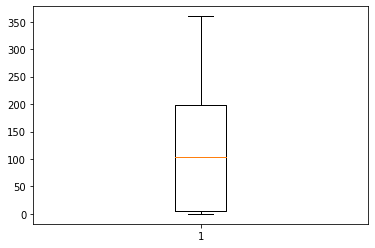

In [229]:
plt.boxplot(final_test['useful'])

tone      rate
tone  1.000000  0.388868
rate  0.388868  1.000000


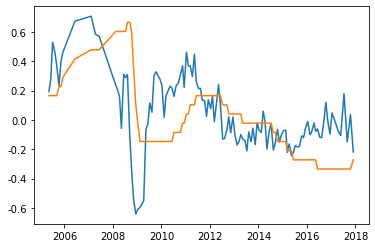

In [234]:
ngram_limit = 104
def tone_sent(x):
    a = 0
    b = 0
    for ngram in x:
        if ngram in hawkish:
            a += 1
        elif ngram in dovish:
            b += 1
    if a+b < ngram_limit:
        return np.nan
    try:
        return (a-b) / (a+b)
    except:
        return np.nan

final_test['tone'] = list(map(tone_sent, final_test['ngram']))
final_test.dropna(inplace=True)
sr_df = pd.read_json('standard_rate.json').set_index('date')
final_test['rate'] = sr_df['rate']




#Scaler
# MaxAbsScaler RobustScaler StandardScaler
import pandas as pd
from sklearn import preprocessing

x = final_test['rate'].values.reshape(-1, 1) #returns a numpy array
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
final_test['rate'] = x_scaled

corr = final_test[['tone','rate']].corr(method = 'pearson')
print(corr)
import matplotlib.pyplot as plt
plt.plot(final_test['tone'])
plt.plot(final_test['rate']-final_test['rate'].mean())
plt.show()

In [184]:
final_test

,ngram,count,tone,rate
date,,,,
2005-05-12,"[소비/NNG;설비/NNG;투자/NNG;내수/NNG;회복/NNG, 경상/NNG;수지...",309,0.192661,0.5000
2005-06-09,"[경상/NNG;수지/NNG;적자/NNG;재정/NNG;적자/NNG, 소비자/NNG;물...",354,0.279279,0.5000
2005-06-23,"[대출/NNG;촉진/NNG, 걸림돌/NNG, 개선/NNG]",28,1.000000,0.5000
2005-07-07,"[자산/NNG;가격/NNG;상승/NNG;물가/NNG;상승/NNG, 금리/NNG;인상...",240,0.528571,0.5000
2005-08-11,"[부동산/NNG;가격/NNG;상승/NNG;금리/NNG;인상/NNG, 은행/NNG;중...",740,0.457364,0.5000
...,...,...,...,...
2017-11-09,"[성장/NNG, 성장/NNG, 기대/NNG;인플레이션/NNG;하락/NNG, 잠재/N...",719,1.000000,0.0000
2017-11-30,"[고용시장/NNG;여건/NNG;개선/NNG, 서비스업/NNG;생산/NNG;늘/VV,...",826,-0.219124,0.0625
2017-12-07,"[은행/NNG;부담/NNG, 부담/NNG, 종료/NNG, 부담/NNG, 기대/NNG...",2,0.000000,0.0625


In [ ]:
import matplotlib.pyplot as plt
plt.plot(final_tone['tone'])
plt.plot(final_tone['rate']-final_tone['rate'].mean())
plt.show()


In [19]:
train_data.sort_values(by='date')

,ngram,ud
date,,
2005-05-01,"[대출/NNG;연체율/NNG;오르/VV, 대출/NNG;연체율/NNG;높/VA, 대출...",0
2005-05-01,"[수입/NNG;증대/NNG, 실적/NNG;높/VV, 하락/NNG, 위험/NNG, 자...",0
2005-05-01,"[무수익여신/NNG;증가/NNG, 수익성/NNG;악화/NNG, 악화/NNG;조짐/N...",0
2005-05-01,"[인플레이션/NNG;압력/NNG;억제/NNG, 금리/NNG;인상/NNG;긴축/NNG...",0
2005-05-01,"[기업/NNG;수익성/NNG;악화/NNG;우려/NNG, 경제/NNG;지표/NNG;성...",0
...,...,...
2017-12-31,"[금리/NNG;제한적/VAX;상승/NNG, 민간/NNG;소비/NNG;개선/NNG, ...",-1
2017-12-31,"[금융시장/NNG;변동성/NNG;확대/NNG, 건전성/NNG;규제/NNG;강화/NN...",-1
2017-12-31,"[선진국/NNG;통화정책/NNG;불확실성/NNG, 통화정책/NNG;불확실성/NNG;...",-1


In [21]:
nbc.df

,0,1,-1,haw,dov,score
ngram,,,,,,
전망/NNG;한계/NNG,9.0,1.0,1.0,0.000002,0.000002,0.973598
전망/NNG;길/VA,8.0,0.0,2.0,0.000000,0.000004,0.000000
금리/NNG;단기/NNG;저점/NNG,11.0,5.0,4.0,0.000010,0.000009,1.216997
위험자산/NNG;투자/NNG;제한/NNG,5.0,0.0,0.0,0.000000,0.000000,NaN
원화/NNG;절상/NNG;기대/NNG;높/VA,5.0,3.0,1.0,0.000006,0.000002,2.920794
...,...,...,...,...,...,...
유동성/NNG;확충/NNG,46.0,14.0,35.0,0.000029,0.000075,0.389439
fed/NNG;금리/NNG;인상/NNG;우려/NNG;높/VA,4.0,1.0,1.0,0.000002,0.000002,0.973598
예상/NNG;자산/NNG;매입/NNG;축소/NNG,11.0,0.0,0.0,0.000000,0.000000,NaN


In [67]:
hawkish

Index(['경제/NNG;성장/NNG;타격/NNG', '경기/NNG;회복/NNG;우려/NNG',
       '전망/NNG;불확실성/NNG;해소/NNG', '서비스업/NNG;지표/NNG;부진/NNG', '비관/NNG;않/VX',
       '소비자/NNG;우려/NNG', '외환시장/NNG;원화/NNG;강세/NNG', '금리/NNG;역마진/NNG;위험/NNG',
       '국제/NNG;유가/NNG;낮/VA', '금융자산/NNG;가격/NNG;상승/NNG',
       ...
       '가계/NNG;부채/NNG;금리/NNG;인상/NNG', '저금리/NNG;양적완화/NNG',
       '금리/NNG;인상/NNG;우려/NNG;둔화/NNG', '변동성/NNG;강화/NNG', '금리/NNG;나쁘/VA;않/VX',
       '펀더멘털/NNG;자신/NNG', 'gdp/NNG;성장률/NNG;상향/NNG',
       '국제/NNG;유가/NNG;원자재/NNG;가격/NNG;상승/NNG', '금리/NNG;가격/NNG;부담/NNG',
       '완화정책/NNG;축소/NNG'],
      dtype='object', name='ngram', length=8684)

In [68]:
dovish

Index(['외환시장/NNG;fed/NNG;금리/NNG;인상/NNG', '심리/NNG;개선/NNG',
       '공급/NNG;과잉/NNG;완화/NNG', '신용등급/NNG;하향/NNG;압력/NNG', '통화정책/NNG;완화/NNG',
       '가격변수/NNG;변동성/NNG;확대/NNG', '수출/NNG;경쟁력/NNG;우려/NNG',
       '비농업/NNG;고용/NNG;지표/NNG;경계/NNG', '건전성/NNG;지표/NNG;개선/NNG',
       '국채/NNG;매입/NNG;중단/NNG',
       ...
       '대출심사/NNG;완화/NNG', '가계/NNG;부채/NNG;문제/NNG;심각/NNG', '가격/NNG;상승/NNG;어렵/VA',
       '회복/NNG;부담/NNG', '지표/NNG;경기/NNG;회복/NNG', '크레딧/NNG;거래/NNG;증가/NNG',
       'fed/NNG;금리/NNG;인상/NNG;우려/NNG;완화/NNG', '공급/NNG;압박/NNG',
       '정책/NNG;효과/NNG;제한/NNG', '유동성/NNG;확충/NNG'],
      dtype='object', name='ngram', length=7985)

In [25]:
test_data = pd.read_json('test_ngram_datas.json')

In [69]:
test_data

,date,ngram,tone,HD,H,D
6251,2017-12-28,[물가/NNG;안정/NNG],1.000000,H,1,0
6252,2017-12-28,"[금융안정/NNG;위험/NNG, 위험/NNG;성장/NNG]",-1.000000,D,0,1
6253,2017-12-28,[통화정책/NNG;완화/NNG],-1.000000,D,0,1
6254,2017-12-28,[금융시스템/NNG;안정/NNG],-1.000000,D,0,1
6255,2017-12-14,[금융안정/NNG],-1.000000,D,0,1
...,...,...,...,...,...,...
29417,2005-05-12,"[둔화/NNG;경제/NNG;지표/NNG;부진/NNG, 지수/NNG;경제/NNG;지표...",1.000000,H,1,0
29418,2005-05-12,"[기업/NNG;실적/NNG;부진/NNG;하락/NNG, 우려/NNG;기업/NNG;실적...",-1.000000,D,0,1
29419,2005-05-12,"[금리/NNG;인상/NNG;전망/NNG;상승/NNG, 유로존/NNG;경제/NNG;부...",-0.200000,D,0,1
29420,2005-05-12,"[금리/NNG;경제/NNG;지표/NNG;부진/NNG;하락/NNG, 안전자산/NNG;...",0.500000,H,1,0


In [28]:
test_data['ngram'] = list(map(lambda i : i.split(','), test_data['ngram']))

In [30]:
test_data['date'] = list(map(lambda i : i.date(), test_data['date']))
test_data = test_data[test_data['date'] <= datetime.date(2017,12,31)]

In [35]:
test_data

,date,ngram,tone,HD,H,D
6251,2017-12-28,[물가/NNG;안정/NNG],1.000000,H,1,0
6252,2017-12-28,"[금융안정/NNG;위험/NNG, 위험/NNG;성장/NNG]",-1.000000,D,0,1
6253,2017-12-28,[통화정책/NNG;완화/NNG],-1.000000,D,0,1
6254,2017-12-28,[금융시스템/NNG;안정/NNG],-1.000000,D,0,1
6255,2017-12-14,[금융안정/NNG],-1.000000,D,0,1
...,...,...,...,...,...,...
29417,2005-05-12,"[둔화/NNG;경제/NNG;지표/NNG;부진/NNG, 지수/NNG;경제/NNG;지표...",1.000000,H,1,0
29418,2005-05-12,"[기업/NNG;실적/NNG;부진/NNG;하락/NNG, 우려/NNG;기업/NNG;실적...",-1.000000,D,0,1
29419,2005-05-12,"[금리/NNG;인상/NNG;전망/NNG;상승/NNG, 유로존/NNG;경제/NNG;부...",-0.200000,D,0,1
29420,2005-05-12,"[금리/NNG;경제/NNG;지표/NNG;부진/NNG;하락/NNG, 안전자산/NNG;...",0.500000,H,1,0


tone      rate
tone  1.000000  0.380343
rate  0.380343  1.000000


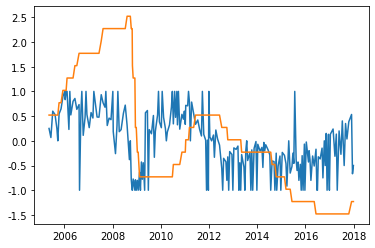

In [72]:
test_data = pd.read_json('test_ngram_datas.json')
test_data['ngram'] = list(map(lambda i : i.split(','), test_data['ngram']))
test_data['date'] = list(map(lambda i : i.date(), test_data['date']))
test_data = test_data[test_data['date'] <= datetime.date(2017,12,31)]

def tone_sent(x):
    a = 0
    b = 0
    for ngram in x:
        if ngram in hawkish:
            a += 1
        elif ngram in dovish:
            b += 1
    try:
        return (a-b) / (a+b)
    except:
        return np.nan
test_data['tone'] = list(map(tone_sent, test_data['ngram']))
test_data.dropna(inplace=True)
# 0은 중립
test_data['HD'] = list(map(lambda i : 'H' if i > 0 else 'D' if i < 0 else np.nan, test_data['tone']))
test_data.dropna(inplace=True)
test_data['H'] = list(map(lambda i : 1 if i == 'H' else 0, test_data['HD']))
test_data['D'] = list(map(lambda i : 1 if i == 'D' else 0, test_data['HD']))
final_tone = test_data.groupby('date').sum()[['H','D']]
final_tone['tone'] = (final_tone['H'] - final_tone['D']) / (final_tone['H'] + final_tone['D'])
sr_df = pd.read_json('standard_rate.json').set_index('date')
final_tone['rate'] = sr_df['rate']
corr = final_tone[['tone','rate']].corr(method = 'pearson')
print(corr)
import matplotlib.pyplot as plt
plt.plot(final_tone['tone'])
# def norm(x):
#     if x - final_tone['rate'].mean() > 0:
#         (x - final_tone['rate'].mean()) / (final_tone['rate'].max() - final_tone['rate'].mean())
#     else:
#         (x - final_tone['rate'].mean()) / (final_tone['rate'].mean() - final_tone['rate'].min())
# final_tone['norm_rate'] = list(map(norm, final_tone['rate']))
plt.plot(final_tone['rate']-final_tone['rate'].mean())
plt.show()